In [1]:
import argparse
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from PIL import Image

import os
import sys
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.patches as patches

#==========================================================================
# JUPYTER PATH STUFF. Not present in the main script coz does not affect it
# =========================================================================

os.chdir("..")


root = Path().resolve()
while root != root.parent:
    if (root / "scripts").is_dir():
        sys.path.insert(0, str(root))
        print("Added to sys.path:", root)
        break
    root = root.parent
else:
    raise RuntimeError("Could not find 'scripts' directory above this notebook")

from scripts.src import (
    build_model_and_tokenizer,
    get_image_transform,
    get_label_text_embeddings,
)

Added to sys.path: /home/woody/iwi5/iwi5362h/ALBEF


In [2]:
from scripts.attention_gradcam import (
    register_albef_attn_gradcam_hooks,
    remove_albef_attn_gradcam_hooks,
    generate_albef_attn_gradcam,
    upsample_cam,
)

In [ ]:
def infer_png_path(images_root: Path, image_id: str) -> Path:
    png_path = images_root / f"{image_id}.png"
    if not png_path.exists():
        raise FileNotFoundError(f"PNG not found for image_id={image_id}: {png_path}")
    return png_path

In [3]:
images_root = Path("/home/woody/iwi5/iwi5362h/data/vindr_cxr/test")
output_dir = Path("/home/woody/iwi5/iwi5362h/ALBEF/results/zero_shot_vindr_results/heatmaps_grad_attn")
output_dir.mkdir(parents=True, exist_ok=True)
config_path = "configs/Pretrain.yaml"
ckpt_path = "output_mimic_a40_transformations/checkpoint_29.pth"
device = "cuda"

In [4]:
torch.cuda.get_device_name(0)

'NVIDIA A40'

In [ ]:
# Load model/tokenizer/config once and reuse
model, tokenizer, config, device = build_model_and_tokenizer(
    config_path=config_path,
    ckpt_path=ckpt_path,
    device=device,
)

image_res = config["image_res"]

transform = get_image_transform(image_res)
model.eval()

# ---- Register Grad-CAM hooks ----
handles = register_albef_attn_gradcam_hooks(model)
print("[Attn-GradCAM] Hooks registered.")

In [ ]:
# Load label CSV to get image_ids + label names
df = pd.read_csv("/home/woody/iwi5/iwi5362h/data/vindr_cxr/annotations/image_labels_test.csv")
id_col = df.columns[0]
all_label_cols = list(df.columns[1:])
print(f"[Data] Found {len(df)} rows, {len(all_label_cols)} labels")

# For debugging a small batch
df = df.iloc[: 100].reset_index(drop=True)
print(f"[Data] Limiting to {len(df)} images (max_images=100)")

df["__has_png__"] = df[id_col].apply(
    lambda x: (images_root / f"{x}.png").exists()
)
df = df[df["__has_png__"]].reset_index(drop=True)
print(f"[Data] After PNG filter: {len(df)} images")

image_ids = df[id_col].tolist()
label_cols = all_label_cols

# Precompute text embeddings for ALL labels in CSV ----
print("[Text] Computing label text embeddings...")
all_label_embs = get_label_text_embeddings(
    model=model,
    tokenizer=tokenizer,
    labels=all_label_cols,
    device=device,
    max_length=32,
)  # (L_all, D)
all_label_embs = F.normalize(all_label_embs, dim=-1)
print("[Text] Done.")

# Map label name -> index into all_label_embs
label_to_idx = {lb: i for i, lb in enumerate(all_label_cols)}

DEBUG_LABELS = ["Pleural effusion", "Cardiomegaly"]

df_labels_full = pd.read_csv("/home/woody/iwi5/iwi5362h/data/vindr_cxr/annotations/image_labels_test.csv")  # image-level labels
id_col_full = df_labels_full.columns[0]

debug_pos_ids = {}
for lb in DEBUG_LABELS:
    if lb not in df_labels_full.columns:
        print(f"[WARN] Debug label '{lb}' not found in labels_csv columns.")
        debug_pos_ids[lb] = set()
        continue
    pos_ids = df_labels_full.loc[df_labels_full[lb] == 1, id_col_full].astype(str).tolist()
    debug_pos_ids[lb] = set(pos_ids)
    print(f"[Debug] {lb}: {len(debug_pos_ids[lb])} positive images")

In [ ]:
# Prepare subset embedding tensor
subset_indices = [label_to_idx[lb] for lb in label_cols]
subset_embs = all_label_embs[subset_indices]  # (L_sub, D)

In [ ]:
# ---- Process images ----
index_records = []
#------DEBUG---------------
cam_debug_records = []
for idx_img, image_id in enumerate(image_ids, start=1):
    try:
        img_path = infer_png_path(images_root, image_id)
    except FileNotFoundError as e:
        print("[WARN]", e)
        continue

    img_pil = Image.open(img_path).convert("RGB")
    img_tensor = transform(img_pil).unsqueeze(0)  # (1,3,H,W)

    heatmaps = {}
    for j, label in enumerate(label_cols):
        text_feat = subset_embs[j]  # (D,)

        cam_patch = generate_albef_attn_gradcam(
            model=model,
            img_tensor=img_tensor,
            text_feat=text_feat,
            device=device,
        )

        # ---- Debug CAM distribution for positive Pleural effusion / Cardiomegaly ----
        if label in debug_pos_ids and image_id in debug_pos_ids[label]:
            cam_vals = cam_patch.detach().cpu().numpy().ravel()

            cam_debug_records.append({
                "image_id": image_id,
                "label": label,
                "cam_min": float(cam_vals.min()),
                "cam_max": float(cam_vals.max()),
                "cam_mean": float(cam_vals.mean()),
                "cam_p90": float(np.percentile(cam_vals, 90)),
                "cam_p95": float(np.percentile(cam_vals, 95)),
                "cam_p99": float(np.percentile(cam_vals, 99)),
            })

        cam_up = upsample_cam(cam_patch, target_size=image_res)  # (H,W)
        heatmaps[label] = cam_up  # tensor

    out_path = output_dir / f"{image_id}.pt"
    heatmaps_cpu = {k: v.float().cpu() for k, v in heatmaps.items()}
    torch.save(heatmaps_cpu, out_path)
    index_records.append(
        {"image_id": image_id, "heatmap_path": str(out_path)}
    )

    if idx_img % 20 == 0 or idx_img == len(image_ids):
        print(f"[Attn-GradCAM] Processed {idx_img}/{len(image_ids)} images")

In [ ]:
# ---- Remove hooks ----
remove_albef_attn_gradcam_hooks(handles)
print("[Attn-GradCAM] Hooks removed.")

In [ ]:
# ---- Save CAM debug stats for positive Pleural effusion / Cardiomegaly ----
if len(cam_debug_records) > 0:
    cam_stats_df = pd.DataFrame(cam_debug_records)
    # cam_stats_path = output_dir / "cam_debug_stats.csv"
    # cam_stats_df.to_csv(cam_stats_path, index=False)
    # print(f"[Debug] Saved CAM stats to: {cam_stats_path}")
else:
    print("[Debug] No CAM stats recorded (no positives for debug labels in processed images).")

In [ ]:
cam_stats_df

In [ ]:
pe = cam_stats_df[cam_stats_df["label"] == "Pleural effusion"]
cardio = cam_stats_df[cam_stats_df["label"] == "Cardiomegaly"]

In [ ]:
print(pe.describe())

In [ ]:
print(cardio.describe())

In [5]:
# Visualization

def load_meta(meta_csv):
    """
    Load VinDr meta CSV with columns: image_id, dim0, dim1
    Returns dict: image_id -> (orig_height, orig_width)
    """
    df = pd.read_csv(meta_csv)
    return {r["image_id"]: (int(r["dim0"]), int(r["dim1"])) for _, r in df.iterrows()}


def visualize_heatmaps_and_gt_per_label(
    image_id: str,
    images_root: str,
    annotations_csv: str,
    meta_csv: str,
    heatmaps_root: str,
    save_dir: str = None,   # OPTIONAL
    alpha: float = 0.45,
    cmap: str = "inferno",
    only_labels=None,
    max_cols: int = 4,      # NEW: max number of columns in the grid
):
    """
    For a given VinDr image:
      - Plot heatmap + GT bounding box *per label instance* in a single grid figure.
      - Always SHOW the combined figure.
      - SAVE ONLY if save_dir is provided.

    If image has K GT boxes (after filtering), we create a grid with K subplots.
    """

    images_root = Path(images_root)
    heatmaps_root = Path(heatmaps_root)
    save_dir = Path(save_dir) if save_dir else None
    if save_dir is not None:
        save_dir.mkdir(parents=True, exist_ok=True)

    # ------------------ Load Annotations ------------------
    df_ann = pd.read_csv(annotations_csv)
    rows = df_ann[df_ann["image_id"] == image_id]
    if rows.empty:
        raise ValueError(f"No annotations found for image_id={image_id}")

    if only_labels is not None:
        rows = rows[rows["class_name"].isin(only_labels)]
        if rows.empty:
            raise ValueError(f"No GT annotations for the requested labels: {only_labels}")

    rows = rows.reset_index(drop=True)
    num_boxes = len(rows)

    # ------------------ Load Original Meta ------------------
    meta = load_meta(meta_csv)
    if image_id not in meta:
        raise KeyError(f"{image_id} not found in meta CSV {meta_csv}")
    orig_h, orig_w = meta[image_id]

    # ------------------ Load Image ------------------
    img_path = images_root / f"{image_id}.png"
    if not img_path.exists():
        raise FileNotFoundError(f"Missing PNG: {img_path}")
    img = Image.open(img_path).convert("RGB")
    w_png, h_png = img.size
    if w_png != 256 or h_png != 256:
        raise AssertionError(f"Expected 256x256 image, got {w_png}x{h_png}")

    scale_x = w_png / float(orig_w)
    scale_y = h_png / float(orig_h)

    # ------------------ Load Heatmaps ------------------
    hm_path = heatmaps_root / f"{image_id}.pt"
    if not hm_path.exists():
        raise FileNotFoundError(f"[Error] Missing heatmap file: {hm_path}")

    heatmaps = torch.load(hm_path, map_location="cpu")
    heatmaps_np = {}
    for label, hm_tensor in heatmaps.items():
        hm = hm_tensor.float()
        # normalize 0–1
        if hm.max() > hm.min():
            hm = (hm - hm.min()) / (hm.max() - hm.min())
        else:
            hm = torch.zeros_like(hm)
        heatmaps_np[label] = hm.detach().cpu().numpy()

    # ------------------ Prepare grid layout ------------------
    n_cols = min(num_boxes, max_cols)
    n_rows = int(np.ceil(num_boxes / n_cols))

    fig, axes = plt.subplots(
        n_rows,
        n_cols,
        figsize=(4 * n_cols, 4 * n_rows),
    )
    # Make axes iterable even if single subplot
    axes = np.array(axes).reshape(-1)

    # ------------------ Iterate Over GT Boxes ------------------
    for k, (_, r) in enumerate(rows.iterrows()):
        ax = axes[k]
        label = r["class_name"]

        if label not in heatmaps_np:
            ax.axis("off")
            print(f"[WARN] No heatmap for label '{label}' → skipping.")
            continue

        heatmap = heatmaps_np[label]

        # Resize heatmap if needed
        H_img, W_img = img.size[1], img.size[0]
        if heatmap.shape != (H_img, W_img):
            heatmap = np.array(
                Image.fromarray((heatmap * 255).astype(np.uint8)).resize(
                    (W_img, H_img), resample=Image.BILINEAR
                )
            ) / 255.0

        # ------------------ Scale GT Box ------------------
        x_min = r["x_min"] * scale_x
        y_min = r["y_min"] * scale_y
        x_max = r["x_max"] * scale_x
        y_max = r["y_max"] * scale_y

        width = x_max - x_min
        height = y_max - y_min

        # ------------------ Draw on subplot ------------------
        ax.imshow(img)
        ax.imshow(heatmap, cmap=cmap, alpha=alpha)

        rect = patches.Rectangle(
            (x_min, y_min),
            width,
            height,
            linewidth=2,
            edgecolor="lime",
            facecolor="none",
        )
        ax.add_patch(rect)

        ax.text(
            x_min,
            max(y_min - 5, 0),
            label,
            fontsize=9,
            color="black",
            bbox=dict(facecolor="yellow", alpha=0.6, edgecolor="none"),
        )
        ax.set_title(f"{label}")
        ax.axis("off")

    # Hide any unused axes (if n_rows * n_cols > num_boxes)
    for j in range(num_boxes, len(axes)):
        axes[j].axis("off")

    fig.suptitle(f"{image_id} — all GT boxes", fontsize=14)
    plt.tight_layout()
    plt.show()

    # SAVE OPTIONAL — single combined figure
    if save_dir is not None:
        out_name = f"{image_id}_all_labels_grid.png"
        out_path = save_dir / out_name
        fig.savefig(out_path, bbox_inches="tight", pad_inches=0, dpi=150)
        print(f"[Saved] {out_path}")

    plt.close(fig)

In [6]:
def visualize_heatmaps_and_gt_per_label_percentile(
    image_id: str,
    images_root: str,
    annotations_csv: str,
    meta_csv: str,
    heatmaps_root: str,
    save_dir: str = None,   # OPTIONAL
    alpha: float = 0.45,
    cmap: str = "jet",      # high values → red
    only_labels=None,
    percentile: float = None,  # e.g. 95.0 => show top 5% activations
    max_cols: int = 4,         # NEW: max number of columns in the grid
):
    """
    For a given VinDr image:
      - Plot (optionally thresholded) heatmap + GT bounding box *per label instance*
        in a single grid figure.
      - Always SHOW the combined figure.
      - SAVE ONLY if save_dir is provided.

    If `percentile` is not None (e.g. 95.0), we:
      - compute threshold T = percentile(heatmap),
      - set values < T to 0,
      - keep values >= T and re-normalize them to [0,1],
      - so the hottest regions appear red with a 'jet' colormap.
    """

    images_root = Path(images_root)
    heatmaps_root = Path(heatmaps_root)
    save_dir = Path(save_dir) if save_dir else None
    if save_dir is not None:
        save_dir.mkdir(parents=True, exist_ok=True)

    # ------------------ Load Annotations ------------------
    df_ann = pd.read_csv(annotations_csv)
    rows = df_ann[df_ann["image_id"] == image_id]
    if rows.empty:
        raise ValueError(f"No annotations found for image_id={image_id}")

    if only_labels is not None:
        rows = rows[rows["class_name"].isin(only_labels)]
        if rows.empty:
            raise ValueError(f"No GT annotations for the requested labels: {only_labels}")

    rows = rows.reset_index(drop=True)
    num_boxes = len(rows)

    # ------------------ Load Original Meta ------------------
    meta = load_meta(meta_csv)
    if image_id not in meta:
        raise KeyError(f"{image_id} not found in meta CSV {meta_csv}")
    orig_h, orig_w = meta[image_id]

    # ------------------ Load Image ------------------
    img_path = images_root / f"{image_id}.png"
    if not img_path.exists():
        raise FileNotFoundError(f"Missing PNG: {img_path}")
    img = Image.open(img_path).convert("RGB")
    w_png, h_png = img.size
    if w_png != 256 or h_png != 256:
        raise AssertionError(f"Expected 256x256 image, got {w_png}x{h_png}")

    scale_x = w_png / float(orig_w)
    scale_y = h_png / float(orig_h)

    # ------------------ Load Heatmaps ------------------
    hm_path = heatmaps_root / f"{image_id}.pt"
    if not hm_path.exists():
        raise FileNotFoundError(f"[Error] Missing heatmap file: {hm_path}")

    heatmaps = torch.load(hm_path, map_location="cpu")
    heatmaps_np = {}
    for label, hm_tensor in heatmaps.items():
        hm = hm_tensor.float()
        # normalize 0–1
        if hm.max() > hm.min():
            hm = (hm - hm.min()) / (hm.max() - hm.min())
        else:
            hm = torch.zeros_like(hm)
        heatmaps_np[label] = hm.detach().cpu().numpy()

    # ------------------ Prepare grid layout ------------------
    n_cols = min(num_boxes, max_cols)
    n_rows = int(np.ceil(num_boxes / n_cols))

    fig, axes = plt.subplots(
        n_rows,
        n_cols,
        figsize=(4 * n_cols, 4 * n_rows),
    )
    axes = np.array(axes).reshape(-1)

    # ------------------ Iterate Over GT Boxes ------------------
    for k, (_, r) in enumerate(rows.iterrows()):
        ax = axes[k]
        label = r["class_name"]

        if label not in heatmaps_np:
            ax.axis("off")
            print(f"[WARN] No heatmap for label '{label}' → skipping.")
            continue

        heatmap = heatmaps_np[label]

        # Resize heatmap if needed
        H_img, W_img = img.size[1], img.size[0]
        if heatmap.shape != (H_img, W_img):
            heatmap = np.array(
                Image.fromarray((heatmap * 255).astype(np.uint8)).resize(
                    (W_img, H_img), resample=Image.BILINEAR
                )
            ) / 255.0

        # ------------------ Top-percentile continuous heatmap ------------------
        if percentile is not None:
            thr = np.percentile(heatmap, percentile)
            hm_clipped = np.copy(heatmap)
            hm_clipped[heatmap < thr] = 0.0

            max_val = hm_clipped.max()
            if max_val > 0:
                hm_clipped = hm_clipped / max_val
            hm_to_show = hm_clipped
        else:
            hm_to_show = heatmap

        # ------------------ Scale GT Box ------------------
        x_min = r["x_min"] * scale_x
        y_min = r["y_min"] * scale_y
        x_max = r["x_max"] * scale_x
        y_max = r["y_max"] * scale_y

        width = x_max - x_min
        height = y_max - y_min

        # ------------------ Draw on subplot ------------------
        ax.imshow(img)
        ax.imshow(hm_to_show, cmap=cmap, alpha=alpha)

        rect = patches.Rectangle(
            (x_min, y_min),
            width,
            height,
            linewidth=2,
            edgecolor="lime",
            facecolor="none",
        )
        ax.add_patch(rect)

        ax.text(
            x_min,
            max(y_min - 5, 0),
            label,
            fontsize=9,
            color="black",
            bbox=dict(facecolor="yellow", alpha=0.6, edgecolor="none"),
        )

        title_suffix = f" (top {percentile}%)" if percentile is not None else ""
        ax.set_title(f"{label}{title_suffix}")
        ax.axis("off")

    # Hide unused axes
    for j in range(num_boxes, len(axes)):
        axes[j].axis("off")

    title_suffix_global = f" — top {percentile}%" if percentile is not None else ""
    fig.suptitle(f"{image_id}{title_suffix_global}", fontsize=14)
    plt.tight_layout()
    plt.show()

    # SAVE OPTIONAL — combined figure
    if save_dir is not None:
        out_name = f"{image_id}_all_labels_grid"
        if percentile is not None:
            out_name += f"_top{int(percentile)}"
        out_name += ".png"

        out_path = save_dir / out_name
        fig.savefig(out_path, bbox_inches="tight", pad_inches=0, dpi=150)
        print(f"[Saved] {out_path}")

    plt.close(fig)

In [7]:
annotations_csv = Path("/home/woody/iwi5/iwi5362h/data/vindr_cxr/annotations/annotations_test.csv")
meta_csv = Path("/home/woody/iwi5/iwi5362h/data/vindr_cxr/test_meta.csv")
heatmaps_root_attn = Path("/home/woody/iwi5/iwi5362h/ALBEF/results/zero_shot_vindr_results/heatmaps_grad_attn")
heatmaps_root_hooks = Path("/home/woody/iwi5/iwi5362h/ALBEF/results/zero_shot_vindr_results/heatmaps_grad_hooks")

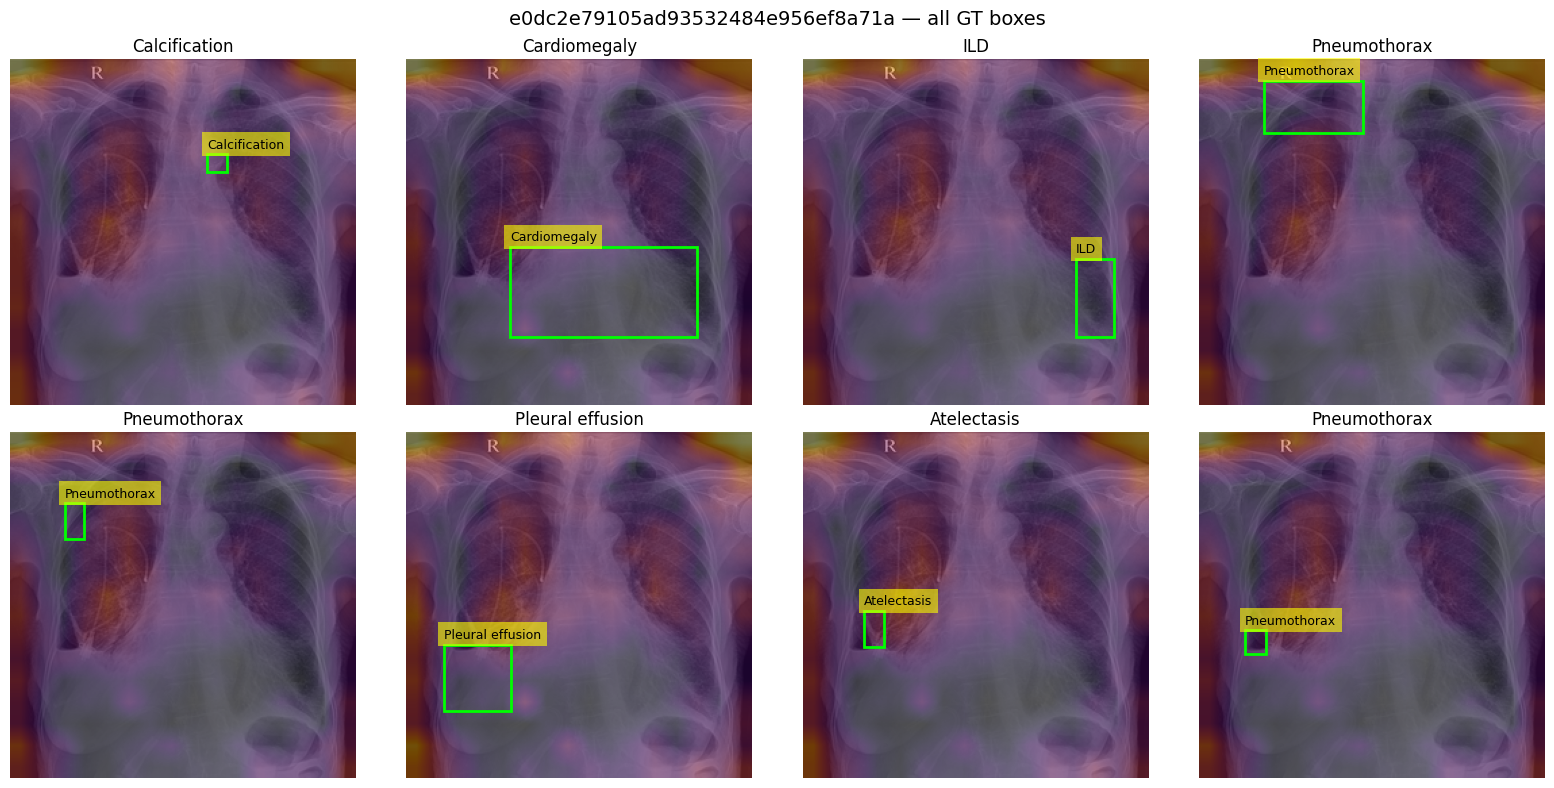

In [8]:
visualize_heatmaps_and_gt_per_label(
    image_id="e0dc2e79105ad93532484e956ef8a71a",
    images_root="/home/woody/iwi5/iwi5362h/data/vindr_cxr/test/",
    annotations_csv=annotations_csv,
    meta_csv=meta_csv,
    heatmaps_root=heatmaps_root_attn,
)

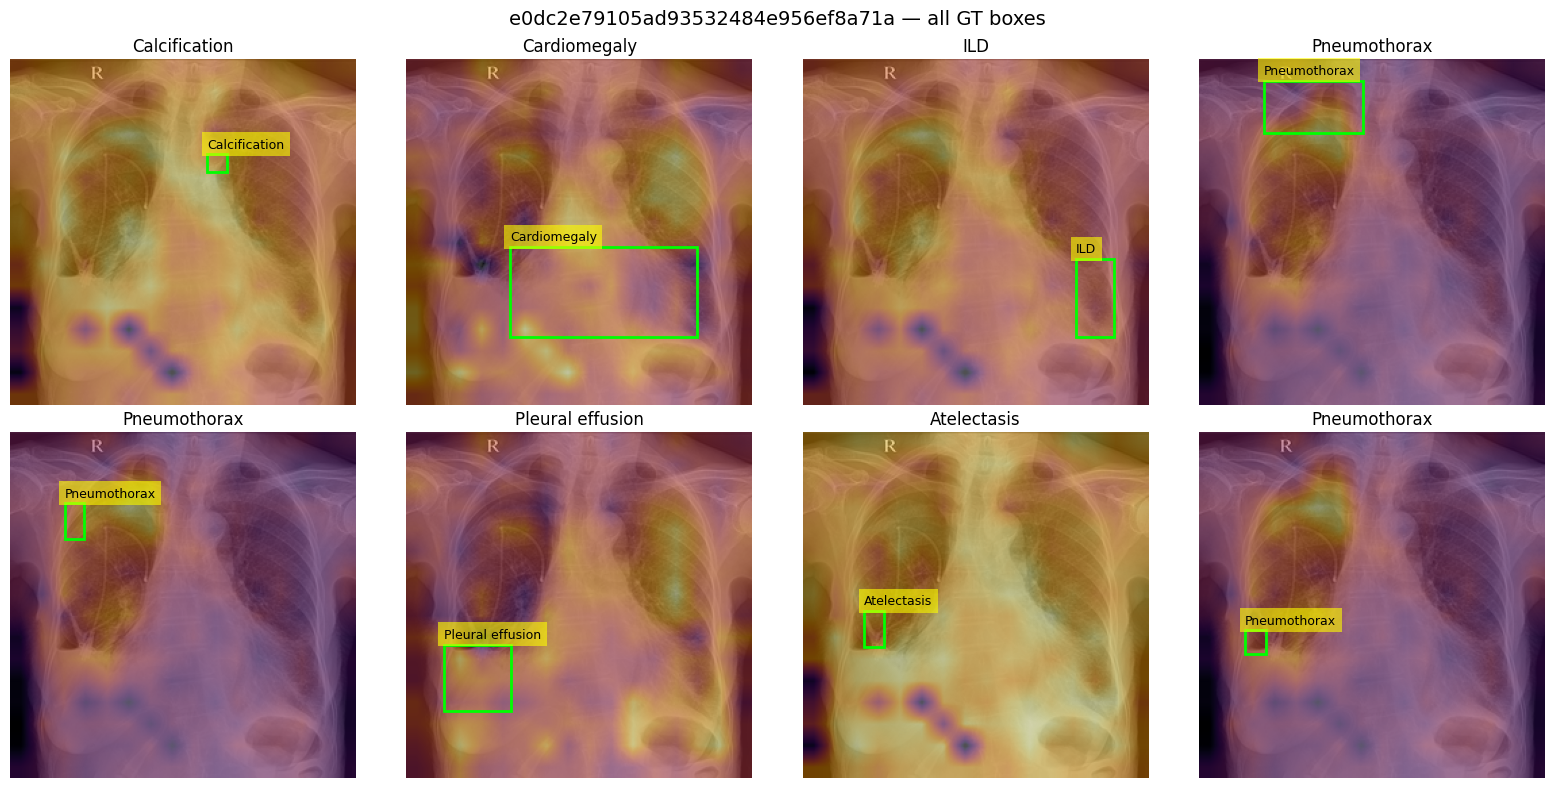

In [9]:
# Previous results

visualize_heatmaps_and_gt_per_label(
    image_id="e0dc2e79105ad93532484e956ef8a71a",
    images_root="/home/woody/iwi5/iwi5362h/data/vindr_cxr/test/",
    annotations_csv=annotations_csv,
    meta_csv=meta_csv,
    heatmaps_root=heatmaps_root_hooks,
)

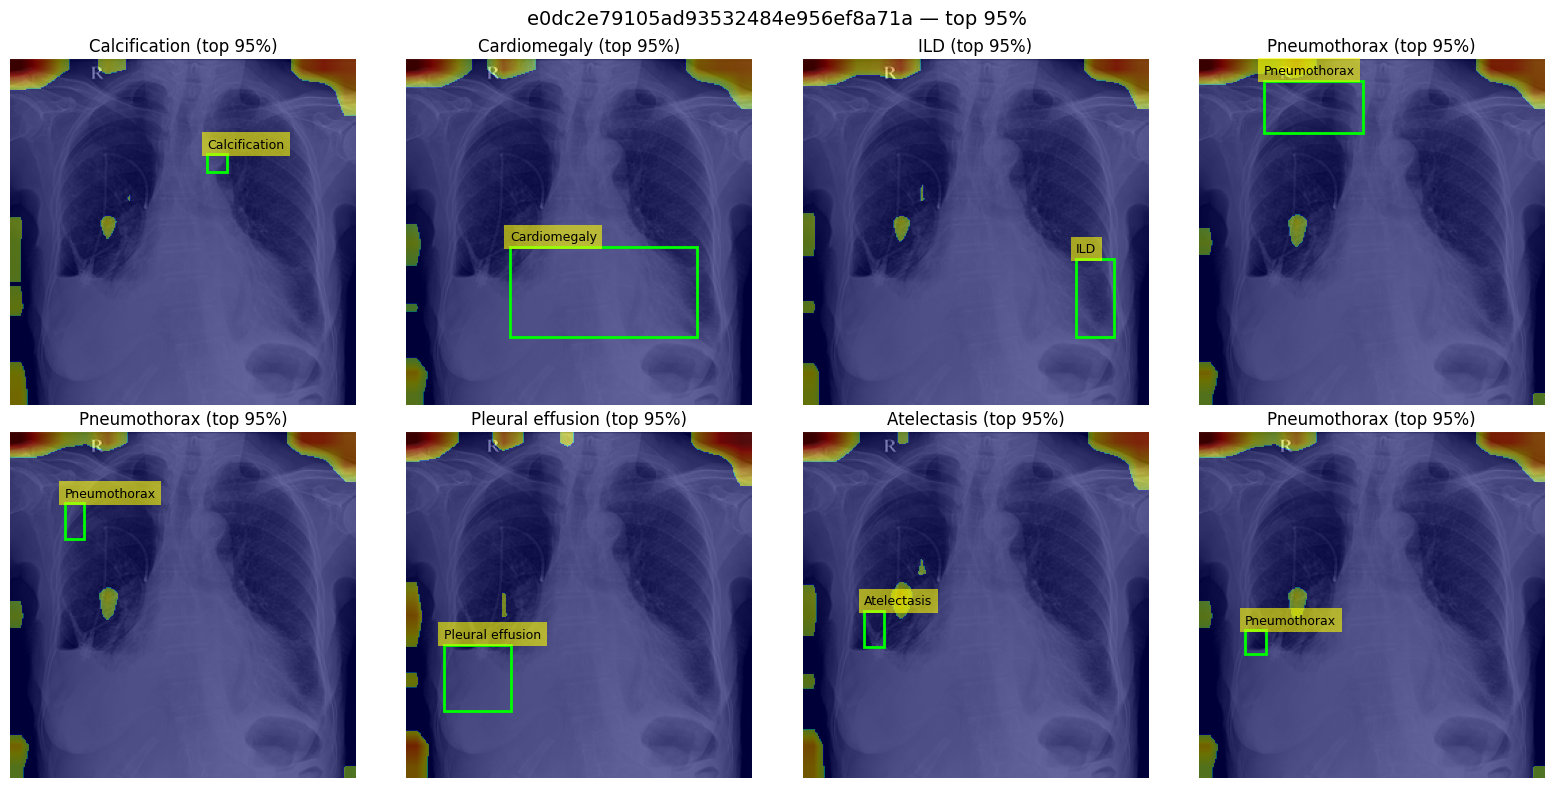

In [10]:
visualize_heatmaps_and_gt_per_label_percentile(
    image_id="e0dc2e79105ad93532484e956ef8a71a",
    images_root="/home/woody/iwi5/iwi5362h/data/vindr_cxr/test/",
    annotations_csv=annotations_csv,
    meta_csv=meta_csv,
    heatmaps_root=heatmaps_root_attn,
    percentile=95
)

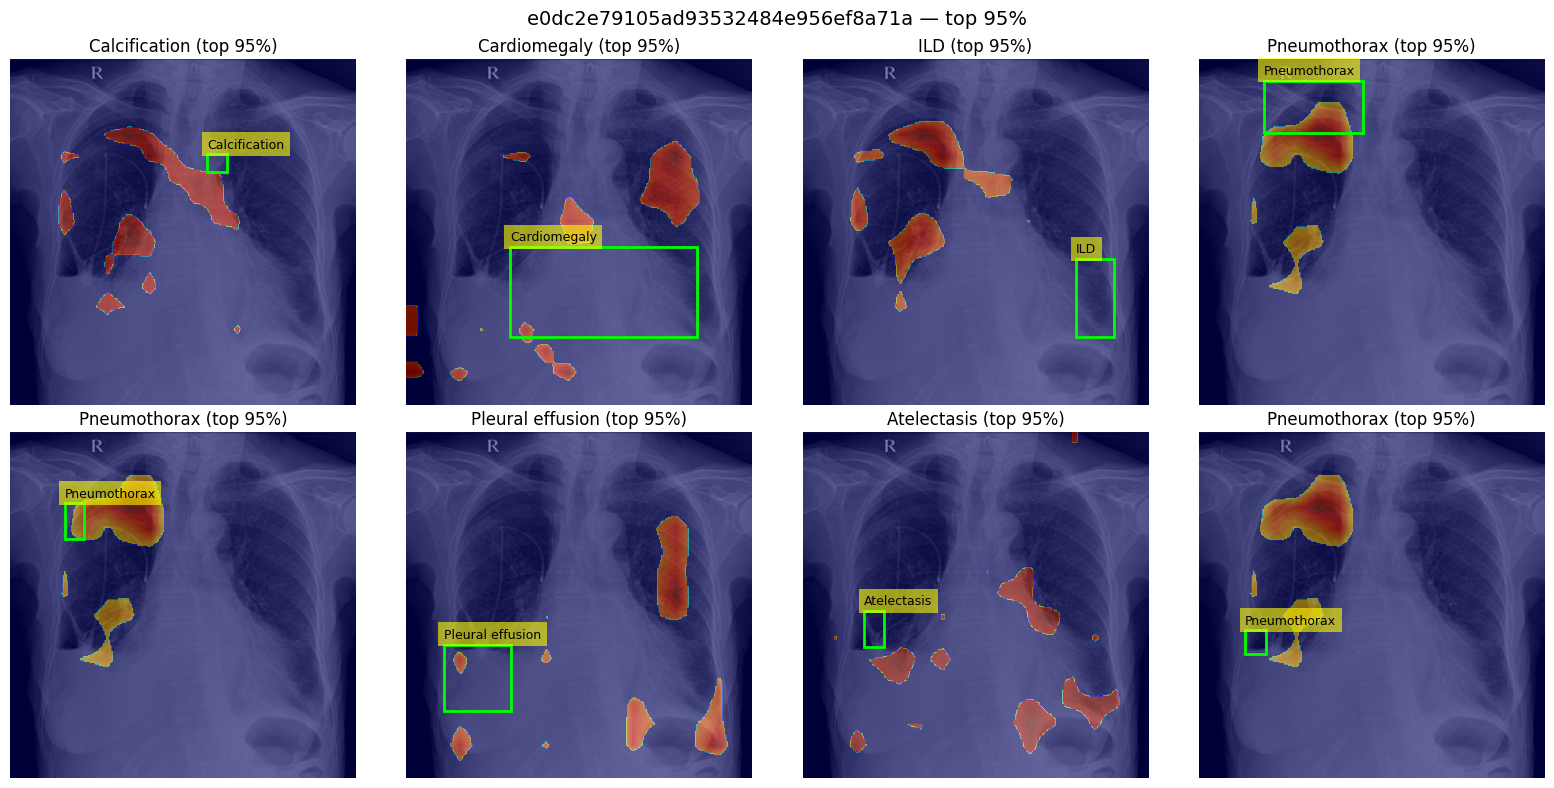

In [11]:
# Previous results

visualize_heatmaps_and_gt_per_label_percentile(
    image_id="e0dc2e79105ad93532484e956ef8a71a",
    images_root="/home/woody/iwi5/iwi5362h/data/vindr_cxr/test/",
    annotations_csv=annotations_csv,
    meta_csv=meta_csv,
    heatmaps_root=heatmaps_root_hooks,
    percentile=95
)